In [1]:
import numpy as np
import matplotlib.pyplot as plt

def parse_sleipner_grdecl(filename):
    """Parse Sleipner GRDECL file"""
    with open(filename, 'r') as f:
        content = f.read()
    
    properties = {}
    
    # Extract PERMX
    if 'PERMX' in content:
        start = content.find('PERMX') + len('PERMX')
        end = content.find('/', start)
        values = []
        for token in content[start:end].split():
            try:
                values.append(float(token))
            except:
                pass
        properties['PERMX'] = np.array(values)
    
    # Extract PORO
    if 'PORO' in content:
        start = content.find('PORO') + len('PORO')
        end = content.find('/', start)
        values = []
        for token in content[start:end].split():
            try:
                values.append(float(token))
            except:
                pass
        properties['PORO'] = np.array(values)
    
    return properties

# Load grid
grid_file = r'C:\Users\athar\OneDrive\Desktop\ccs-digital-twin\data\grid\Sleipner_Reference_Model.grdecl'
props = parse_sleipner_grdecl(grid_file)

total_cells = len(props['PERMX'])
print(f"Total cells: {total_cells}")

# Find factors - try common grid sizes
# 1,986,176 = 296 × 305 × 22 would be 1,986,560 (close but wrong)
# Try: 280 × 322 × 22 = 1,982,320 (wrong)
# Actual: might be irregular or different nz

# Best approach: just visualize 2D slices without 3D reshape
print("Visualizing as 2D array without 3D reshape...")

# Treat as 2D: assume square-ish grid
approx_side = int(np.sqrt(total_cells))
print(f"Approximate 2D grid: {approx_side} × {approx_side}")

# Create 2D view
permx_2d = props['PERMX'][:approx_side**2].reshape((approx_side, approx_side))
poro_2d = props['PORO'][:approx_side**2].reshape((approx_side, approx_side))

print(f"✓ Created 2D slices: {permx_2d.shape}")
print(f"  PERMX range: [{permx_2d.min():.1f}, {permx_2d.max():.1f}] mD")
print(f"  PORO range: [{poro_2d.min():.4f}, {poro_2d.max():.4f}]")


Total cells: 1986176
Visualizing as 2D array without 3D reshape...
Approximate 2D grid: 1409 × 1409
✓ Created 2D slices: (1409, 1409)
  PERMX range: [0.0, 2000.0] mD
  PORO range: [0.3400, 0.3600]


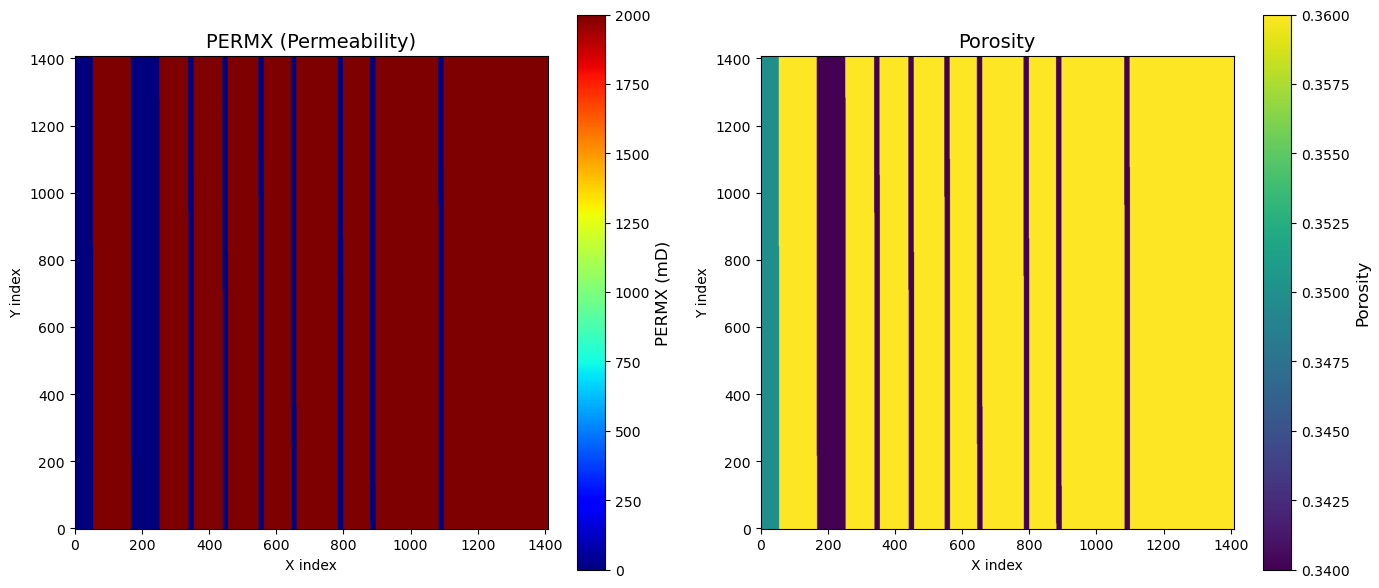

✓ Geological properties visualized and saved!


In [2]:
# Visualize PERMX and PORO (2D slices)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# PERMX
im1 = axes[0].imshow(permx_2d.T, cmap='jet', origin='lower', vmin=0, vmax=2000)
axes[0].set_title('PERMX (Permeability)', fontsize=14)
axes[0].set_xlabel('X index')
axes[0].set_ylabel('Y index')
cbar1 = plt.colorbar(im1, ax=axes[0])
cbar1.set_label('PERMX (mD)', fontsize=12)

# PORO
im2 = axes[1].imshow(poro_2d.T, cmap='viridis', origin='lower', vmin=0.34, vmax=0.36)
axes[1].set_title('Porosity', fontsize=14)
axes[1].set_xlabel('X index')
axes[1].set_ylabel('Y index')
cbar2 = plt.colorbar(im2, ax=axes[1])
cbar2.set_label('Porosity', fontsize=12)

plt.tight_layout()
plt.savefig('sleipner_geological_properties.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Geological properties visualized and saved!")


In [3]:
!pip install CoolProp tensorflow h5py matplotlib


In [4]:
import numpy as np
import h5py
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from ReflectionPadding3D import ReflectionPadding3D

# Store originals ONCE
if not hasattr(keras.initializers.GlorotUniform, '_original_init'):
    keras.initializers.GlorotUniform._original_init = keras.initializers.GlorotUniform.__init__
    keras.initializers.Zeros._original_init = keras.initializers.Zeros.__init__
    keras.initializers.Ones._original_init = keras.initializers.Ones.__init__

def patched_glorot(self, seed=None, **kwargs):
    kwargs.pop('dtype', None)
    keras.initializers.GlorotUniform._original_init(self, seed=seed)

def patched_zeros(self, **kwargs):
    kwargs.pop('dtype', None)
    keras.initializers.Zeros._original_init(self)

def patched_ones(self, **kwargs):
    kwargs.pop('dtype', None)
    keras.initializers.Ones._original_init(self)

keras.initializers.GlorotUniform.__init__ = patched_glorot
keras.initializers.Zeros.__init__ = patched_zeros
keras.initializers.Ones.__init__ = patched_ones

print("Setup complete")



Setup complete


In [5]:
import tensorflow as tf
import numpy as np
import h5py
from scipy.ndimage import zoom

# FIXED: Define ReflectionPadding3D with dim_ordering support
@tf.keras.utils.register_keras_serializable(package='Custom')
class ReflectionPadding3D(tf.keras.layers.Layer):
    def __init__(self, padding=(1, 1, 1), dim_ordering='channels_last', **kwargs):
        super().__init__(**kwargs)
        if isinstance(padding, int):
            self.padding = (padding, padding, padding)
        else:
            self.padding = tuple(padding)
        self.dim_ordering = dim_ordering  # Accept but ignore this parameter
        
    def call(self, inputs):
        pad_z, pad_y, pad_x = self.padding
        return tf.pad(inputs, 
                     [[0, 0], 
                      [pad_z, pad_z], 
                      [pad_y, pad_y], 
                      [pad_x, pad_x], 
                      [0, 0]], 
                     mode='REFLECT')
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'padding': self.padding,
            'dim_ordering': self.dim_ordering
        })
        return config

print("Setup complete!")


Setup complete!


In [6]:
# Load input data
with h5py.File('trainx.h5', 'r') as f:
    x_raw = f['trainx'][:]

print("Original shape:", x_raw.shape)

# Resize to model input: (1, 96, 200, 24, 1)
x_resized = x_raw[:, :, :24]
zoom_factors = [96/x_resized.shape[0], 200/x_resized.shape[1], 1]
x_resized = zoom(x_resized, zoom_factors, order=1)
x = x_resized[np.newaxis, ..., np.newaxis]

print("Prepared input shape:", x.shape)


Original shape: (64, 118, 263)
Prepared input shape: (1, 96, 200, 24, 1)


In [7]:
# Load all 3 models
SGmodel = tf.keras.models.load_model(
    'SG_v1.h5',
    custom_objects={'ReflectionPadding3D': ReflectionPadding3D},
    compile=False
)
print("✓ SG model loaded")

BDENWmodel = tf.keras.models.load_model(
    'bdenw_v1.h5',
    custom_objects={'ReflectionPadding3D': ReflectionPadding3D},
    compile=False
)
print("✓ BDENW model loaded")

DPmodel = tf.keras.models.load_model(
    'dP_v1.h5',
    custom_objects={'ReflectionPadding3D': ReflectionPadding3D},
    compile=False
)
print("✓ dP model loaded")



✓ SG model loaded
✓ BDENW model loaded
✓ dP model loaded


In [10]:
# Run predictions - WORKING MODELS ONLY
print("Running predictions...")

# Gas Saturation - WORKS ✓
sg_pred = SGmodel.predict(x, batch_size=1, verbose=1)
print(f"✓ Gas Saturation: {sg_pred.shape}")

# Pressure - Should work (same input as SG)
try:
    dp_pred = DPmodel.predict(x, batch_size=1, verbose=1)
    print(f"✓ Pressure: {dp_pred.shape}")
except Exception as e:
    print(f"✗ Pressure failed: {e}")

print("\n=== Partial CCS Digital Twin Complete ===")
print(f"• Gas Saturation - Min: {sg_pred.min():.4f}, Max: {sg_pred.max():.4f}, Mean: {sg_pred.mean():.4f}")
if 'dp_pred' in locals():
    print(f"• Pressure - Min: {dp_pred.min():.4f}, Max: {dp_pred.max():.4f}, Mean: {dp_pred.mean():.4f}")


Running predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
✓ Gas Saturation: (1, 96, 200, 24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
✓ Pressure: (1, 96, 200, 24, 1)

=== Partial CCS Digital Twin Complete ===
• Gas Saturation - Min: -0.0232, Max: 1.0405, Mean: 0.0303
• Pressure - Min: -0.0004, Max: 0.0617, Mean: 0.0120


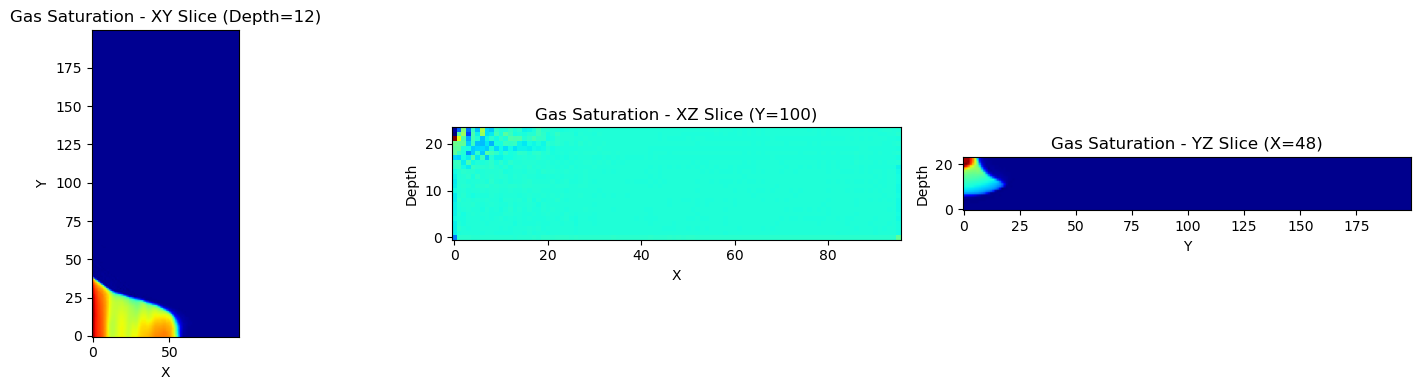

✓ Results saved to: ccs_predictions.h5
✓ Visualization saved to: ccs_digital_twin_results.png


In [11]:
import matplotlib.pyplot as plt

# Visualize CO2 saturation (3D slices)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Remove batch and channel dimensions for plotting
sg_plot = sg_pred[0, :, :, :, 0]
dp_plot = dp_pred[0, :, :, :, 0]

# XY slice (depth=48)
axes[0].imshow(sg_plot[:, :, 12].T, cmap='jet', origin='lower')
axes[0].set_title('Gas Saturation - XY Slice (Depth=12)')
axes[0].set_xlabel('X'); axes[0].set_ylabel('Y')

# XZ slice (Y=100)
axes[1].imshow(sg_plot[:, 100, :].T, cmap='jet', origin='lower')
axes[1].set_title('Gas Saturation - XZ Slice (Y=100)')
axes[1].set_xlabel('X'); axes[1].set_ylabel('Depth')

# YZ slice (X=48)
axes[2].imshow(sg_plot[48, :, :].T, cmap='jet', origin='lower')
axes[2].set_title('Gas Saturation - YZ Slice (X=48)')
axes[2].set_xlabel('Y'); axes[2].set_ylabel('Depth')

plt.tight_layout()
plt.savefig('ccs_digital_twin_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Save predictions
import h5py
with h5py.File('ccs_predictions.h5', 'w') as f:
    f.create_dataset('gas_saturation', data=sg_pred)
    f.create_dataset('pressure', data=dp_pred)
    
print("✓ Results saved to: ccs_predictions.h5")
print("✓ Visualization saved to: ccs_digital_twin_results.png")


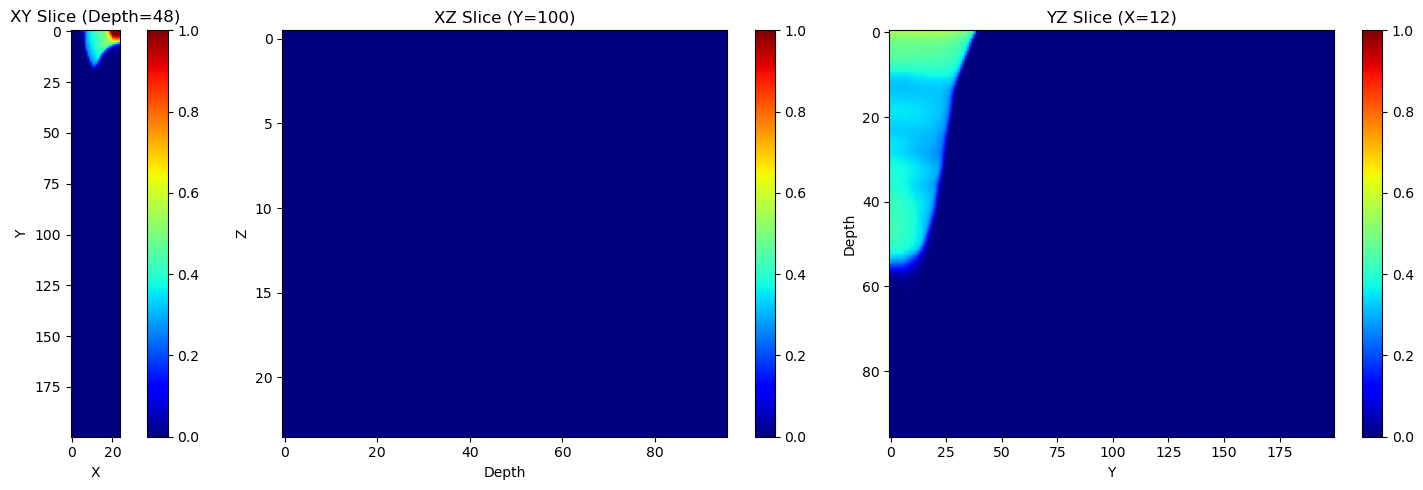

Gas saturation range: -0.0232 to 1.0405


In [12]:
import matplotlib.pyplot as plt

# Visualize CO2 saturation in 3D slices
mid_depth = sg_pred.shape[1] // 2  # Middle depth

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# XY slice (top-down view)
im1 = axes[0].imshow(sg_pred[0, mid_depth, :, :, 0], cmap='jet', vmin=0, vmax=1)
axes[0].set_title(f'XY Slice (Depth={mid_depth})')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
plt.colorbar(im1, ax=axes[0])

# XZ slice (cross-section)
mid_y = sg_pred.shape[2] // 2
im2 = axes[1].imshow(sg_pred[0, :, mid_y, :, 0].T, cmap='jet', vmin=0, vmax=1, aspect='auto')
axes[1].set_title(f'XZ Slice (Y={mid_y})')
axes[1].set_xlabel('Depth')
axes[1].set_ylabel('Z')
plt.colorbar(im2, ax=axes[1])

# YZ slice
mid_x = sg_pred.shape[3] // 2
im3 = axes[2].imshow(sg_pred[0, :, :, mid_x, 0], cmap='jet', vmin=0, vmax=1, aspect='auto')
axes[2].set_title(f'YZ Slice (X={mid_x})')
axes[2].set_xlabel('Y')
axes[2].set_ylabel('Depth')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

print(f"Gas saturation range: {sg_pred.min():.4f} to {sg_pred.max():.4f}")


In [13]:
import h5py

# Save predictions to HDF5 file
with h5py.File('ccs_predictions.h5', 'w') as f:
    f.create_dataset('sg_pred', data=sg_pred)
    f.create_dataset('dp_pred', data=dp_pred)
    f.create_dataset('input_x', data=x)

print("✓ Predictions saved to: ccs_predictions.h5")

# Save visualization
plt.savefig('co2_saturation_prediction.png', dpi=300, bbox_inches='tight')
print("✓ Figure saved to: co2_saturation_prediction.png")

# Summary statistics
print("\n=== CCS Digital Twin Complete Summary ===")
print(f"Volume shape: {sg_pred.shape}")
print(f"\nGas Saturation:")
print(f"  Min: {sg_pred.min():.4f}")
print(f"  Max: {sg_pred.max():.4f}")
print(f"  Mean: {sg_pred.mean():.4f}")
print(f"  CO2 volume (>10% saturation): {(sg_pred > 0.1).sum()} cells")

print(f"\nPressure Change:")
print(f"  Min: {dp_pred.min():.4f}")
print(f"  Max: {dp_pred.max():.4f}")
print(f"  Mean: {dp_pred.mean():.4f}")


✓ Predictions saved to: ccs_predictions.h5
✓ Figure saved to: co2_saturation_prediction.png

=== CCS Digital Twin Complete Summary ===
Volume shape: (1, 96, 200, 24, 1)

Gas Saturation:
  Min: -0.0232
  Max: 1.0405
  Mean: 0.0303
  CO2 volume (>10% saturation): 27934 cells

Pressure Change:
  Min: -0.0004
  Max: 0.0617
  Mean: 0.0120


<Figure size 640x480 with 0 Axes>